In [1]:
import datetime as dt
from datetime import timedelta
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
import re
import os

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [3]:
data_folder = "data/"
!ls $data_folder

asset_details.csv             supplemental_train.csv
example_sample_submission.csv train.csv
example_test.csv


In [4]:
crypto_df = pd.read_csv(data_folder + 'train.csv')

In [5]:
pd.to_datetime(crypto_df['timestamp'], unit='s')
crypto_df.index = crypto_df['timestamp']

In [6]:
btc = crypto_df[crypto_df['Asset_ID'] == 1].set_index("timestamp")
#data preprocessing
#filling the gaps in time series
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')


In [7]:
# Calculate daily returns as percentage price changes
btc = btc.loc[(btc != 0.0).any(axis=1)]
btc['Return'] = np.log(btc['Close']).diff().mul(100) # rescale to faciliate optimization
btc = btc.dropna()
btc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956022 entries, 1514764920 to 1632181440
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
 9   Return    float64
dtypes: float64(9), int64(1)
memory usage: 164.2 MB


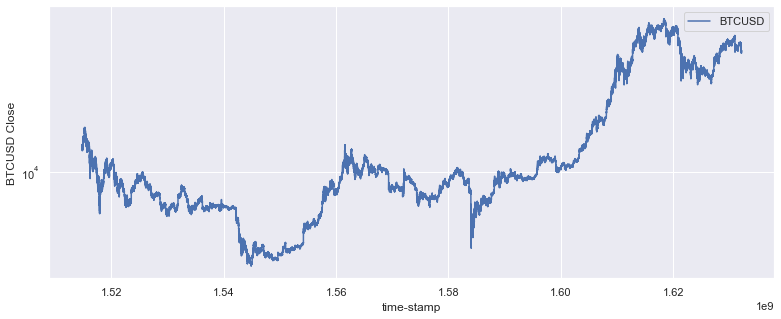

In [8]:
# Plot bitcoin price data 
fig, ax1 = plt.subplots(figsize=(13, 5))
ax1.set_yscale('log')
ax1.plot(btc.index, btc.Close, color='b', label='BTCUSD')
ax1.set_xlabel('time-stamp')
ax1.set_ylabel('BTCUSD Close')
ax1.legend()
plt.show()

In [9]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(btc['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:            2.31565e+06
Distribution:      Standardized Student's t   AIC:                      -4.63129e+06
Method:                  Maximum Likelihood   BIC:                      -4.63121e+06
                                              No. Observations:              1956022
Date:                      Tue, Dec 14 2021   Df Residuals:                  1956021
Time:                              19:24:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [10]:
# Specify GARCH model assumptions
basic_gm = arch_model(btc['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     45,   Neg. LLF: -2101454.4428343168
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2101454.4346422325
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


In [11]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:            2.10145e+06
Distribution:                  Normal   AIC:                      -4.20290e+06
Method:            Maximum Likelihood   BIC:                      -4.20285e+06
                                        No. Observations:              1956022
Date:                Tue, Dec 14 2021   Df Residuals:                  1956021
Time:                        19:24:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.3733e-04  7.888e-05      4.276  1.899e-05 [1.

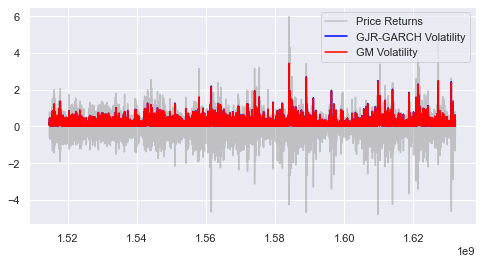

In [12]:
gjrgm_vol = gjrgm_result.conditional_volatility
gm_vol = gm_result.conditional_volatility

# Plot the actual Bitcoin returns
plt.plot(btc['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot general model  estimated volatility
plt.plot(gm_vol, color = 'red', label = 'GM Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [13]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'GM BIC: {gm_result.bic}')

GJR-GARCH BIC: -4631212.475826056
GM BIC: -4202850.923590957


In [14]:
newdt = dt.datetime.fromtimestamp(0)
btc['timestamp'] = btc.index
#btc.timestamp = dt.datetime.fromtimestamp(btc.timestamp)
btc['timestamp'] = pd.to_datetime(btc['timestamp'], unit='s')
btc.timestamp = btc.timestamp.dt.tz_localize('UTC')
btc.index = btc.timestamp
# 1970-01-01 09:00:00

In [15]:
# Specify GJR-GARCH model assumptions
gjr_gm2 = arch_model(btc['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result2 = gjr_gm2.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result2.summary())

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:            2.31565e+06
Distribution:      Standardized Student's t   AIC:                      -4.63129e+06
Method:                  Maximum Likelihood   BIC:                      -4.63121e+06
                                              No. Observations:              1956022
Date:                      Tue, Dec 14 2021   Df Residuals:                  1956021
Time:                              19:24:25   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [16]:
index = btc.index
start_loc = 0
end_loc = np.where(index >= '2020-01-01')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = gjr_gm2.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


--

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


--

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


--

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


--

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 Done!


In [17]:
index = btc.index
start_loc = 0
end_loc = np.where(index >= '2020-01-01')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = gjr_gm2.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


--

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 Done!


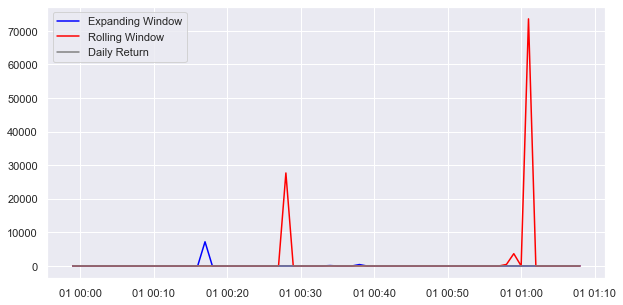

In [46]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin,dtype='float')

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin,dtype='float')

# Plot results
plt.figure(figsize=(10,5))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(btc.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

In [19]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gjrgm_result.params,
                             'p-value': gjrgm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter       p-value
mu         0.000058  7.502203e-02
omega      0.000298  0.000000e+00
alpha[1]   0.200000  0.000000e+00
gamma[1]   0.010000  5.877835e-13
beta[1]    0.775000  0.000000e+00
nu         4.383320  0.000000e+00


In [20]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gjrgm_result.params,
                             'std-err': gjrgm_result.std_err, 
                             't-value': gjrgm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print parameter stats
print(para_summary)

          parameter   std-err     t-value
mu         0.000058  0.000033    1.780330
omega      0.000298  0.000004   68.632456
alpha[1]   0.200000  0.001342  149.000653
gamma[1]   0.010000  0.001388    7.203286
beta[1]    0.775000  0.002296  337.529344
nu         4.383320  0.068906   63.613492


In [21]:
# Obtain model estimated residuals and volatility
gm_resid = gjrgm_result.resid
gm_std = gjrgm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std


In [22]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,8.309477e-33,1.859133e-72,9.292022e-85,3.022624e-84,4.079405e-84,2.880136e-91,3.647596e-114,4.811710e-124,3.531779e-136,3.496643e-136


In [23]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,8.309477e-33,1.859133e-72,9.292022e-85,3.022624e-84,4.079405e-84,2.880136e-91,3.647596e-114,4.811710e-124,3.531779e-136,3.496643e-136


In [24]:
# Specify GARCH model assumptions
skewt_gm = arch_model(btc['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

/Users/shreyasingh/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


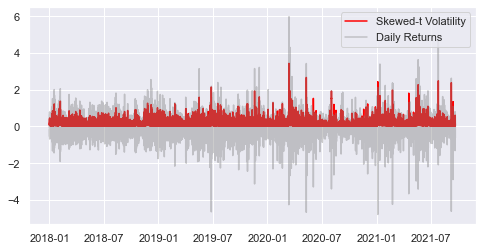

In [25]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(btc['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [26]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : 2101454.4346422325
Log-likelihood of skewt GARCH : 2314827.099623136


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [28]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE of general model
evaluate(btc['Return'].sub(btc['Return'].mean()).pow(2), gm_vol**2)

Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.011


(0.016868759645124253, 0.010777166074666642)

In [29]:
evaluate(btc['Return'].sub(btc['Return'].mean()).pow(2), gjrgm_vol**2)

Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.011


(0.016866691195066293, 0.010771508174893977)

In [30]:
evaluate(btc.Return.loc[variance_expandwin.index], vol_fixedwin)

Mean Absolute Error (MAE): 1505.38
Mean Squared Error (MSE): 88465258.66


(1505.3802332469347, 88465258.6602996)

In [31]:
evaluate(btc.Return.loc[variance_expandwin.index], vol_expandwin)

Mean Absolute Error (MAE): 110.392
Mean Squared Error (MSE): 742893.876


(110.39174556623864, 742893.8763454659)

In [33]:
from scipy.stats import pearsonr
corr, _ = pearsonr(btc['Return'].sub(btc['Return'].mean()).pow(2), gjrgm_vol**2)

In [34]:
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.434


In [35]:
corr2, _ = pearsonr(btc['Return'].sub(btc['Return'].mean()).pow(2), gm_vol**2)
print('Pearsons correlation: %.3f' % corr2)

Pearsons correlation: 0.432


In [38]:
corr3, _ = pearsonr(btc['Return'].sub(btc['Return'].mean()).pow(2), skewt_vol**2)
print('Pearsons correlation: %.3f' % corr3)

Pearsons correlation: 0.432


In [59]:
original = btc.Return.loc[variance_fixedwin.index].values
forecasted =vol_fixedwin.values.flatten()

In [60]:
corr4, _ = pearsonr(forecasted, original)
print('Pearsons correlation: %.3f' % corr4)

Pearsons correlation: 0.066


In [61]:
original2 = btc.Return.loc[variance_expandwin.index].values
forecasted2 =vol_expandwin.values.flatten()

In [62]:
corr5, _ = pearsonr(forecasted2, original2)
print('Pearsons correlation: %.3f' % corr5)

Pearsons correlation: -0.164
